# Projet Python 2020 : Un GPS personnalisé pour les cyclistes
**Projet Python - 2A ENSAE** 

Fares Imane, Desbois Vinciane, Gajdos Romane 

## Introduction : 

**Nos objectifs :** Nous sommes parties des bases de données disponibles sur data.gouv et qui nous semblaient intéressantes d'un point de vue visualisation, manipulation et modélisation. Initialement nous voulions travailler sur l'intermodalité des moyens de transports verts. Mais les données disponibles ne nous permettaient pas de le faire. Nous avons finalement trouvé des données sur les aménagements cyclables en Ile-de-France et avons eu l'idée de faire un GPS pour vélo. 

**Le projet :** Nous avons dans un premier temps réalisé un travail de visualisation des données que nous allions utiliser pour le GPS : les aménagements cyclables, les stations de vélo en libre service et les accidents de vélo. Vinciane a ensuite découvert la bibliothèque Folium qui a grandement orienté notre travail. Nous avons laissé de côté la base aménagements cyclables pour utiliser les données OpenStreetMap via Folium. Les cartes obtenues correspondent davantage à un GPS : elles sont interactives et affichent la totalité des routes. Nous avons ensuite construit le GPS avec deux options principales : si l'utilisateur a son propre vélo ou s'il souhaite empreinter un vélo en libre service. Nous avons ensuite rajouté des options à notre GPS : un module de prévention concernant les accidents de vélo, un indicateur de congestion et un module météo en temps réel. 

## Les importations : 

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import folium
from folium.plugins import MarkerCluster
import os
import time
import datetime

In [2]:
import pyroutelib3
from pyroutelib3 import Router
import requests, json
import urllib.parse
import tempfile
import zipfile

In [3]:
import tkinter as tk
from tkinter import simpledialog
from tkinter import messagebox
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [4]:
departements = gpd.read_file('https://www.data.gouv.fr/fr/datasets/r/ec305e78-f231-4a77-b32c-1e0c4c67615e')
dpt = departements[departements['code_departement'].isin(['75', '77', '78', '91', '92', '93', '94', '95' ])]

## I] Visualisation des données

### 1) Les pistes (Romane)

On représente les différents type d'aménagements cyclables en Ile-de-France, groupés en 7 catégories : bande cyclable, piste cyclable, tottoir, voie propre, voie verte, double sens cyclable non marqué. 

Que voulez-vous afficher ? 
bande, piste, trottoir, voie bus, voie propre, voie verte, double sens cyclable non marqué, toutpiste, trottoir, voie bus


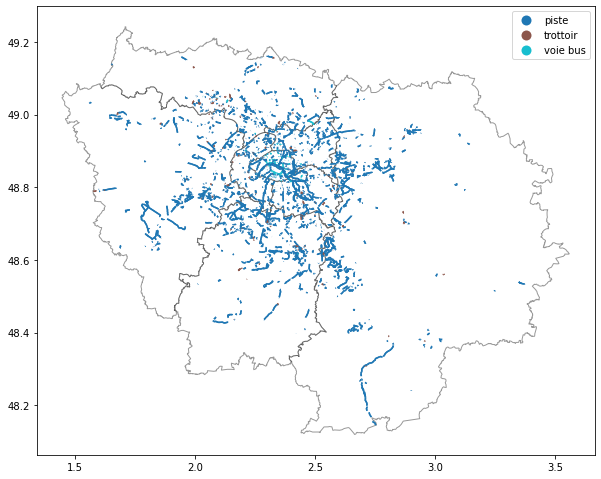

In [9]:
%run "./Visualisation_pistes.ipynb"

### 2) Les vélos en libre-service (Imane)

#### Velib - disponibilité en temps réel

Données disponibles au lien suivant : 
https://smartregionidf.opendatasoft.com/explore/dataset/velib-disponibilite-en-temps-reel/export/?disjunctive.name&disjunctive.is_installed&disjunctive.is_renting&disjunctive.is_returning&disjunctive.nom_arrondissement_communes

In [98]:
velib = gpd.read_file("https://smartregionidf.opendatasoft.com/explore/dataset/velib-disponibilite-en-temps-reel/download/?format=geojson&timezone=Europe/Berlin&lang=fr")

#### Cristolib et Vélo2 en libre-service à Créteil

Données disponibles aux liens suivants : 
- https://smartregionidf.opendatasoft.com/explore/dataset/jcdecaux-bike-stations-data/information/


In [100]:
velos2 = gpd.read_file('https://smartregionidf.opendatasoft.com/explore/dataset/jcdecaux-bike-stations-data/download/?format=geojson&timezone=Europe/Berlin&lang=fr')

#### Veligo

Données disponibles au lien suivant : https://smartregionidf.opendatasoft.com/explore/dataset/points-de-contact-veligo-location/information/

In [101]:
veligo = gpd.read_file('https://smartregionidf.opendatasoft.com/explore/dataset/points-de-contact-veligo-location/download/?format=geojson&timezone=Europe/Berlin&lang=fr')

#### Fusion des bases de données Vélib, Veligo et Velos2

In [102]:
#Ajout d'une colonne correspondant au type du vélo (vélib, véligo ou vélos2)

velib["type"]=["velib" for i in range(velib.shape[0])]
veligo["type"]=["veligo" for i in range(veligo.shape[0])]
velos2["type"]=["velos2" for i in range(velos2.shape[0])]

In [103]:
# Ajout d'une colonne disponibilité vélos pour ceux qui n'en ont pas

veligo["numbikesavailable"]=["N" for i in range(veligo.shape[0])]

#velib["numbikesavailable"][1:velib.shape[0]]=[0 for i in range(1, velib.shape[0])]

#velos2["available_bikes"]=[0 for i in range(velos2.shape[0])]

# Ajout d'une colonne disponibilité docks pour ceux qui n'en ont pas 

veligo["numdocksavailable"]=["N" for i in range(veligo.shape[0])]

In [104]:
# Selectionner et renommer les colonnes de chaque base

velib = velib[["name","geometry","type", "numbikesavailable", "numdocksavailable"]]

veligo = veligo [["nom","geometry","type","numbikesavailable", "numdocksavailable"]]
veligo.columns = ['name','geometry',"type","numbikesavailable", "numdocksavailable"]

velos2 = velos2 [["name", "geometry","type","available_bikes", "available_bike_stands"]]
velos2.columns = ['name','geometry',"type","numbikesavailable", "numdocksavailable"]

In [105]:
velos = pd.concat([veligo, velib, velos2], ignore_index=True)

In [106]:
velos.shape

(2530, 5)

In [107]:
velos.shape[0] ==  veligo.shape[0] + velib.shape[0] + velos2.shape[0] 

True

In [108]:
velos

,name,geometry,type,numbikesavailable,numdocksavailable
0,ST MAUR DES FOSSES PDC,POINT (2.49129 48.80253),veligo,N,N
1,BRY PPDC1,POINT (2.52455 48.82955),veligo,N,N
2,CRETEIL PPDC1,POINT (2.45490 48.77790),veligo,N,N
3,FONTENAY SOUS BOIS PDC1,POINT (2.47531 48.84936),veligo,N,N
4,IVRY PDC1,POINT (2.40150 48.80670),veligo,N,N
...,...,...,...,...,...
2525,56106 - ERA06 - CENTRE TECHNIQUE MUNICIPAL,POINT (2.09846 49.01122),velos2,8,16
2526,50006 - CER06 - LE CHAT PERCHÉ,POINT (2.02695 49.04896),velos2,3,13
2527,53102 - SOA02 - GARE SOA CENTRE,POINT (2.10571 49.04625),velos2,5,14
2528,53101 - SOA01 - PLACE CARNOT (CB),POINT (2.10304 49.04778),velos2,4,15


In [42]:
departements = gpd.read_file('https://www.data.gouv.fr/fr/datasets/r/ec305e78-f231-4a77-b32c-1e0c4c67615e')
dpt = departements[departements['code_departement'].isin(['75', '77', '78', '91', '92', '93', '94', '95' ])]

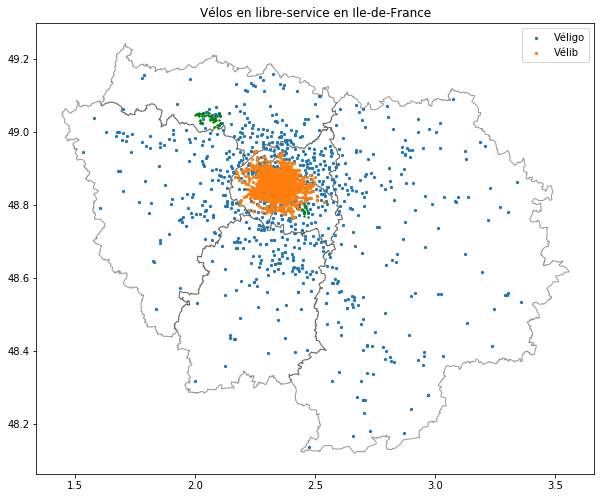

In [43]:
fig, ax = plt.subplots(figsize = (10,10))
dpt.plot(ax=ax, color = 'white', edgecolor = 'black', alpha = 0.4)

velos[velos["type"]=="veligo"].plot(ax=ax, color='tab:blue', label = 'Véligo', markersize=5)
velos[velos["type"]=="velib"].plot(ax=ax, color='tab:orange', label = 'Vélib', markersize=5)
velos[velos["type"]=="velos2"].plot(ax=ax, color='green', markersize=2)

plt.title('Vélos en libre-service en Ile-de-France')
plt.legend()
plt.show()

In [44]:
centre = [48.8534 , 2.3488] #Centre de paris 
idf = folium.Map(location = centre, zoom_start = 13)
idf

### 3) Les accidents (Vinciane)

In [ ]:
accident_velo = pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/3d5f2317-5afd-4a9f-a9c5-bd4fe0113f39')
accident_velo_idf = accident_velo[accident_velo['departement'].isin(['75','77','78','91','92','93','94','95'])]
accident_velo_idf = accident_velo_idf[['identifiant accident','lat','lon','gravite accident']]
accident_velo_idf.head(10)

In [ ]:
#On transforme les coordonnées latitudes/longitudes en coordonnées lisibles par géopandas
gdf = gpd.GeoDataFrame(accident_velo_idf, geometry=gpd.points_from_xy(accident_velo_idf.lon, accident_velo_idf.lat))
gdf = gdf.cx[1.44:3.57,48.12:49.2] #Nombreuses coordonnées manquantes, et quelques valeurs aberrantes éliminées
gdf  
#Au total, il nous reste 3400 données sur les 18 000  

In [ ]:
#Des clusters sont faits automatiquement par secteur ou les points sont proches
Paris = [48.85, 2.34]
map_accident = folium.Map(location = Paris , zoom_start=12)
marker_cluster = MarkerCluster().add_to(map_accident)

lat = gdf.lat
lng = gdf.lon
for lat, lng in zip(lat, lng):
    folium.Marker(location=[lat,lng],
    icon = folium.Icon(color='red', icon_color='black', icon='bicycle', prefix='fa'),
    ).add_to(marker_cluster)
    
map_accident

#### Analyses sur la gravité des accidents

In [ ]:
indemne = gdf[gdf['gravite accident']  == '0 - Indemne'][['lat', 'lon']]
blesse_leg = gdf[gdf['gravite accident']  == '1 - Blessé léger'][['lat', 'lon']]
blesse_hosp = gdf[gdf['gravite accident']  == '2 - Blessé hospitalisé'][['lat', 'lon']]
tue =gdf[gdf['gravite accident']  == '3 - Tué'][['lat', 'lon']]

In [ ]:
# Carte différenciant la gravité des accidents
Paris = [48.85, 2.34]
map_accident = folium.Map(location = Paris , zoom_start=10)

lat = indemne.lat
lng = indemne.lon
for lat, lng in zip(lat, lng):
        folium.Marker(location=[lat,lng],icon = folium.Icon(color='white', icon_color='black', icon='bicycle', prefix='fa')).add_to(map_accident)
lat = blesse_leg.lat
lng = blesse_leg.lon
for lat, lng in zip(lat, lng):
        folium.Marker(location=[lat,lng],icon = folium.Icon(color='beige', icon_color='black', icon='bicycle', prefix='fa')).add_to(map_accident)
lat = blesse_hosp.lat
lng = blesse_hosp.lon
for lat, lng in zip(lat, lng):
        folium.Marker(location=[lat,lng],icon = folium.Icon(color='lightred', icon_color='black', icon='bicycle', prefix='fa')).add_to(map_accident)
lat = tue.lat
lng = tue.lon
for lat, lng in zip(lat, lng):
        folium.Marker(location=[lat,lng],icon = folium.Icon(color='red', icon_color='black', icon='bicycle', prefix='fa')).add_to(map_accident)

map_accident

## II] Personnalisation du GPS

### 1) Un GPS qui prend en compte les accidents (Vinciane)

#### Les clusters d'accident avec la méthode DBSCAN

On utilise DBSCAN, qui permet de créer un cluster avec : 
- epsilon : la distance entre deux accidents liés au même lieu accidentogène. Nous avons choisi comme distance 50m.
- min_samples : le nombre de point minimum pour créer un cluster. Nous avons choisi 3 points, car 2 accidents au même endroit pourraient n'être dûs qu'à une coïncidence.

In [ ]:
X=gdf.loc[:,['lat','lon']]
kms_per_radian = 6371 
epsilon = 0.05/kms_per_radian

In [ ]:
#centre cluster
def get_centroid(cluster): 
    cluster_ary = np.asarray(cluster) 
    centroid = cluster_ary.mean(axis=0) 
    return centroid 

In [ ]:
dbsc = (DBSCAN(eps=epsilon, min_samples=3).fit(X)) 

X_labels = dbsc.labels_ 
num_clusters = len(set(dbsc.labels_)) 
print("Le nombre de clusters est de", num_clusters)
dbsc_clusters = pd.Series([X[X_labels==n] for n in range(num_clusters)]) 
cluster_centroids = dbsc_clusters.map(get_centroid) 

gdf['Xc_labelse'] = X_labels
gdf_filtered = gdf[X_labels>-1]


cent_lat, cent_lon = zip(*cluster_centroids)
centroids_df = pd.DataFrame({'lon':cent_lon, 'lat':cent_lat}) 
print("Le nombre d'accidents qui rentrent dans les clusters est de ", len(gdf_filtered))

In [ ]:
fig, ax = plt.subplots(figsize=[11, 8]) 
dpt.plot(ax=ax, color='0.9', edgecolor='black')

accident_scatter = ax.scatter(gdf['lon'], gdf['lat'], c ='midnightblue',alpha=0.25, s=50) 
centroid_scatter = ax.scatter(centroids_df['lon'], centroids_df['lat'],marker='x', linewidths=2, c='gold', s=50) 

ax.set_title("Clusters d'accidents et le centre des lieux accidentés", fontsize =20) 
ax.set_xlabel('Longitude', fontsize=12) 
ax.set_ylabel('Latitude', fontsize =12) 
ax.legend([accident_scatter, centroid_scatter], ['Accident', "Centre d'un cluster d'accident"], loc='upper right', fontsize = 12) 
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=[8, 6]) 
dpt.plot(ax=ax, color='0.9', edgecolor='black')
filtres_scatter = ax.scatter(gdf_filtered['lon'], gdf_filtered['lat'],  c= 'red', alpha =0.25, s=50) 
centroid_scatter = ax.scatter(centroids_df['lon'], centroids_df['lat'],marker='x', linewidths=2, c='k', s=50) 
ax.set_title("Clusters d'accidents et le centre des lieux accidentés, sans les bruits", fontsize = 20) 
ax.set_xlabel('Longitude', fontsize = 16) 
ax.set_ylabel('Latitude', fontsize = 16) 
axes = plt.gca()
axes.set_xlim(2.00, 2.70)
axes.set_ylim(48.4, 49.1)
ax.legend([accident_scatter, centroid_scatter], ["Accident au sein d'un cluster", "Centre d'un cluster d'accident"], loc='upper right', fontsize = 12)
plt.show()

In [ ]:
centroids_df = centroids_df.dropna() #On trouve 1 valeur manquante, on l'enlève
centroids_df #Liste des lieux particulièrement accidentogènes en Ile-de-France

### 2) Un GPS qui informe sur les conditions météréologiques (Vinciane)

#### La météo en temps réel

In [ ]:
##On cherche l'heure et la date de la requête par le cycliste: 
time.strftime('%Y-%m-%d %H:%M:%S', time.localtime()) #Date et heure
Date = time.strftime('%Y-%m-%d', time.localtime()) #Date
Time = time.strftime('%H:%M', time.localtime()) #Heure
DateTime = time.strftime('%Y-%m-%dT%H:%M:%S', time.localtime()) 
print('Voic la date de la recherche : ', Date)
print("Voici l'heure de la recherche :", Time)
print(DateTime, 'heure')

In [ ]:
meteo_gpd = 'https://www.data.gouv.fr/fr/datasets/r/8e834f69-0b43-439a-87bd-87ca80c84cd7'
meteo_idf = gpd.read_file(meteo_gpd) 
#Base de donnée avec prévisions pour les 36h après sa mise à jour 

In [ ]:
meteo_idf = meteo_idf[['timestamp', 'forecast', '2_metre_temperature', 'total_water_precipitation',  'geometry']]
meteo_idf.head(10)

D'après la documentation, 

- La colonne "total_water_precipitation" correspond au cumul (depuis le début de la simulation) de la somme des flux au sol des précipitations liquides et solides (eau, neige, grêlons) en kg/m-2
- La colonne "2_metre_temperature" est la température diagnostiquée à 2m de hauteur au dessus du relief

In [ ]:
meteo_idf["duration"] = pd.to_datetime(meteo_idf["forecast"]) - pd.to_datetime(meteo_idf["timestamp"])
meteo_idf["duration"] = meteo_idf["duration"].astype("timedelta64[m]")
#Différence en minutes entre la prévision et l'heure prévue
meteo_idf = meteo_idf.cx[2.35,48.85] 
#On ne garde que les prévisions pour le centre de Paris ce qu'on suppose représentatif de la météo pour toute l'Ile-de-France
meteo_idf = meteo_idf.sort_values('forecast')

In [ ]:
meteo_idf2 = meteo_idf.reset_index()

In [ ]:
for i in range(1,len(meteo_idf2)):
    meteo_idf2.loc[i, 'diff_precipitation'] = meteo_idf2.loc[i,'total_water_precipitation']-meteo_idf2.loc[i-1,'total_water_precipitation']
#Parfois des erreurs dans la conception des données, lorsque "duree" est négative (impossible car signifierait que la somme des précipitations diminue dans le temps)
#Pour négliger ces erreurs, on remplace les valeurs négatives par 0
meteo_idf2.loc[(meteo_idf2["diff_precipitation"]<0), "diff_precipitation"] = 0

In [ ]:
meteo_idf2.head(8)

In [ ]:
for i in range(1,len(meteo_idf2)):
    meteo_idf2.loc[i, 'duree_intervalle'] = meteo_idf2.loc[i,'duration']-meteo_idf2.loc[i-1,'duration']

Conversion des données de précipitations en kg/m-2 en données mesurées en mm/h :
On a 1L/m² =1mm, et 1kg d'eau = 1L d'eau, d'où : 
- précipitation en 1h = (précipitations pendant l'intervalle)/(duree intervalle)*60 

La manière de mesurer les précipitations la plus répandue est la pluviométrie, qui correspond à la hauteur d'eau recueillie sur une surface plane (exprimée en mm). 
On sépare l'intensité de la pluie : 
- pluie très faible et négligeable  (de 0 à 2 mm/h)
- modérée et forte (plus 2 mm/h)

In [ ]:
meteo_idf2["precipitations mm/h"] = ((meteo_idf2["diff_precipitation"])/(meteo_idf2["duree_intervalle"]))*60
##A vérifier
meteo_idf3 = meteo_idf2[['forecast', '2_metre_temperature','precipitations mm/h']]
meteo_idf3.sort_values('forecast').head(5)

In [ ]:
meteo_idf_temps_reel = meteo_idf2.loc[meteo_idf2['forecast'] <= DateTime][['forecast', '2_metre_temperature', 'precipitations mm/h' ]].sort_values('forecast').tail(1)
# On fait en rognant l'heure et non en approximant => voir si améliorable ou pas
meteo_idf_temps_reel

In [ ]:
if meteo_idf_temps_reel['precipitations mm/h'].item()> 2.000 and (meteo_idf_temps_reel['2_metre_temperature'].item() > -1 or meteo_idf_temps_reel['2_metre_temperature'].item()) < 1:
    print('Attention il pleut et il y a peut-être du verglas sur la chaussée.')
elif meteo_idf_temps_reel['precipitations mm/h'].item() > 2.000 and (meteo_idf_temps_reel['2_metre_temperature'].item() < -1 or meteo_idf_temps_reel['2_metre_temperature'].item()) > 1:
    print("Attention il pleut, mais normalement, il n'y a pas de verglas sur la chaussée")
elif meteo_idf_temps_reel['precipitations mm/h'].item() < 2.00 and (meteo_idf_temps_reel['2_metre_temperature'].item() > -1 or meteo_idf_temps_reel['2_metre_temperature'].item()) < 1:
    print("Il ne pleut pas, mais attention, il peut y avoir du verglas.")
else:
    print("Quel chanceux, il n'y a ni pluie ni verglas.")
print('Pendant votre trajet il fera une température de',round(meteo_idf_temps_reel['2_metre_temperature'].item(),2), 'degrès.')

#### Les heures de lever et de coucher du soleil : 

Base de donnée à télécharger par année sur le site : http://ptaff.ca/
Elle est sur Github

In [ ]:
heures_soleil = pd.read_csv('D:/Données/ENSAE/lever_coucher_soleil.csv',  sep = ',')
heures_soleil.loc[heures_soleil['Date'] == Date] 

In [ ]:
heures_soleil.loc[heures_soleil['Date'] == Date]
if  Time >=heures_soleil.loc[heures_soleil['Date'] == Date]['Lever_du_soleil'].any() and Time <=heures_soleil.loc[heures_soleil['Date'] == Date]['Coucher_du_soleil'].any():
    print('Il est', Time,', vous roulez de jour.')
else: 
    print('Il est', Time, "heure",'attention, vous roulez de nuit.')

### 3)  Un GPS qui prend en compte les affluences (Romane)

On utilise les données issues des compteurs installés à Paris (data.gouv). On ignore les variations saisonnières (mois) et hebdomadaires. On ne considère que les variations en fonction des jours de la semaine : un rapide plot montre deux groupes très distincts de moyennes horaire : les jours de la semaine et les jours du week-end. On crée un indice de congestion des pistes cyclables en fonction du jour et de l'heure de la requêtes.  L'indice calculé correspond à la moyenne sur 2019 et 2020 des comptages de chaque compteur au jour de la semaine et à l'heure de la requête. 

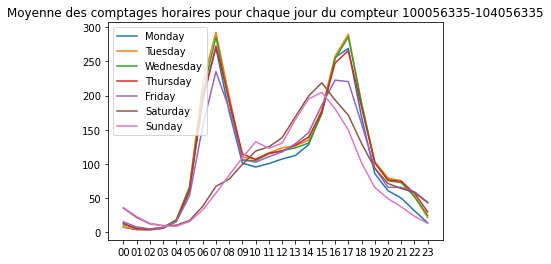

2710711480
411736456
votre trajet existe


In [15]:
%run "./compteurs.ipynb"

A modifier : ici on affiche déjà un trajet et les compteurs les plus proches. Peut-être qu'on peut afficher ici tous les compteurs et seulement dans la partie finale afficher les compteurs autour du trajet ? 

In [14]:
idf

## III] Utilisation du GPS (Imane)

#### Choix du point de départ et du point d'arrivée

In [123]:
adresse_depart =input("D'où partez-vous ? (numéro, rue, code postal ville)")

adresse_arrivee = input("Où voulez-vous aller ? (numéro, rue, code postal ville)")

D'où partez-vous ? (numéro, rue, code postal ville) 5, Avenue Anatole France, 75007 Paris
Où voulez-vous aller ? (numéro, rue, code postal ville) 1, Rue de Rivoli, 75001 Paris


In [20]:
print(adresse_depart)

5, Avenue Anatole France, 75007 Paris


In [21]:
print(adresse_arrivee)

1, Rue de Rivoli, 75001 Paris


In [47]:
#adresse_depart = "5, Avenue Anatole France, 75007 Paris"
#adresse_arrivee = "1, Rue de Rivoli, 75001 Paris"
dep_json = requests.get("https://api-adresse.data.gouv.fr/search/?q=" + urllib.parse.quote(adresse_depart) + "&format=json").json()
arr_json = requests.get("https://api-adresse.data.gouv.fr/search/?q=" + urllib.parse.quote(adresse_arrivee) + "&format=json").json()
coord_dep = list(dep_json['features'][0].get('geometry').get('coordinates'))
coord_arr = list(arr_json['features'][0].get('geometry').get('coordinates'))

In [118]:
x = input("Avez-vous votre propre vélo ? Entrez 'oui' ou 'non' ")

Avez-vous votre propre vélo ? Entrez 'oui' ou 'non'  oui


## Lorsque l'utilisateur n'a pas son propre vélo

In [117]:
if(x=='non'):
                                                                                 
    coor_depart = [coord_dep[1], coord_dep[0]] 
    coor_arrivee = [coord_arr[1], coord_arr[0]] 
    
    # Ré-initialisation de la carte 
    centre = coor_depart 
    idf = folium.Map(location = centre, zoom_start = 13)
    
    # Calcul de la distance en km entre le point de départ et toutes les stations

    distances = []
    for i in range(len(velos.geometry)):
      a = (max(velos.geometry[i].x, coord_dep[0]) - min(velos.geometry[i].x, coord_dep[0]))**2 + (max(velos.geometry[i].y, coord_dep[1]) - min(velos.geometry[i].y, coord_dep[1]))**2
      a = a**(1/2)*100
      distances.append(a)
    
    #Station la plus proche du point de départ 

    i = distances.index(min(distances))

    station_dep = [velos["geometry"][i].y, velos["geometry"][i].x]

    print( 'Station la plus proche du point de départ :', velos["name"][i] )
    
    
    # Vérification disponibilité vélo dans la station de départ
    
    if(velos["numbikesavailable"][i]!="0" and velos["numbikesavailable"][i]!="N" ):
        print("\n \n Un vélo est disponible à la station la plus proche du point de départ")
        
    elif(velos["numbikesavailable"][i]=="N"):
        print("\n \n Nous ne disposons pas d'information concernant la disponibilité d'un vélo à la station la plus proche du point de départ")
        
    elif(velos["numbikesavailable"][i]=="0"):
        print("\n \n Pas de vélo disponible à la station la plus proche du point de départ")

        k = i
        
        while( velos["numbikesavailable"][k]=="0"):
            
            # Nouvelle station la plus proche et avec vélo disponible

            distances.pop(k)
            k = distances.index(min(distances))

            station_dep = [velos["geometry"][k].y, velos["geometry"][k].x]

        print( 'Station la plus proche du point de départ avec vélo disponible : \n', velos["name"][k] )
          
    
    print('\n \nDistance à effectuer à pied (point de départ -> station de départ) :', round(min(distances),2), "km")
    print("soit un temps de trajet d'environ :", round(min(distances)*1000/66.67), "minutes\n \n")
    
    t = min(distances)*1000/66.67
        
    
    # Calcul de la distance en km entre le point d'arrivée et toutes les stations

    distances = []
    for i in range(len(velos.geometry)):
      a = (max(velos.geometry[i].x, coord_arr[0]) - min(velos.geometry[i].x, coord_arr[0]))**2 + (max(velos.geometry[i].y, coord_arr[1]) - min(velos.geometry[i].y, coord_arr[1]))**2
      a = a**(1/2)*100
      distances.append(a)
    
    #Station la plus proche du point d'arrivée

    j = distances.index(min(distances))

    station_arr = [velos["geometry"][j].y, velos["geometry"][j].x] 
    
    print( 'Station la plus proche du point d arrivée : ', velos["name"][j] )
    
    # Vérification disponibilité dock dans la station d'arrivée
    
    if(velos["numdocksavailable"][j]!="0" and velos["numdocksavailable"][j]!="N" ):
        print("\n Un dock est disponible à la station la plus proche du point d'arrivée")
    
    elif(velos["numdocksavailable"][j]=="N"):
        print("\nNous ne disposons pas d'information concernant la disponibilité d'un dock à la station la plus proche du point d'arrivée")
    
    elif(velos["numdocksavailable"][j]=="0"):
        print("\nPas de dock disponible à la station la plus proche du point d'arrivée'")
        
        while( velos["numdocksavailable"][j]=="0"):
            
            # Nouvelle station la plus proche et avec dock disponible

            distances.pop(j)
            j = distances.index(min(distances))

            station_arr = [velos["geometry"][j].y, velos["geometry"][j].x]

        print( "Station la plus proche du point d'arrivée avec dock disponible : \n", velos["name"][k] )
        
    # Durée et distance trajet à vélo
    
    d = (max(station_dep[0], station_arr[0]) - min(station_dep[0], station_arr[0]))**2 + (max(station_dep[1], station_arr[1]) - min(station_dep[1], station_arr[1]))**2
    d = d**(1/2)*100                                                                                                 

    print( '\n \nDistance à effectuer en vélo (station de départ -> station d\'arrivée) :', round(d,2), "km")
    print("soit un temps de trajet d'environ :", round(d*1000/250), "minutes\n")
    print( '\n Distance à effectuer à pied (station d\'arrivée -> point d\'arrivée) :', round(min(distances),2), "km")
    print("soit un temps de trajet d'environ :", round(min(distances)*1000/66.67), "minutes\n \n")
    
    print("Le temps total du trajet est donc de :", round(t+d*1000/250+min(distances)*1000/66.67)  ,"minutes\n \n")
    
    # Si le temps total du trajet calculé > temps de trajet en faisant tout à pied, alors faire le trajet à pied 
    
    d_pied = (max(coord_dep[0], coord_arr[0]) - min(coord_dep[0], coord_arr[0]))**2 + (max(coord_dep[1], coord_arr[1]) - min(coord_dep[1], coord_arr[1]))**2
    d_pied = d_pied**(1/2)*100
    t_pied = d_pied*1000/66.67
    
    if( t+d*1000/250+min(distances)*1000/66.67 > t_pied ):
        
        print("ATTENTION : Il serait plus judicieux de faire tout le trajet à pied car :")
        print("Distance du point de départ au point d'arrivée :", round(d_pied,2), "km")
        print("Temps du trajet à pied :", round(t_pied), "minutes\n" )
            
    #Trajet à pied : point de départ -> station départ

    folium.Marker(coor_depart,popup="Depart").add_to(idf)
    folium.Marker(coor_arrivee,popup="Arrivee").add_to(idf)
    
    router = pyroutelib3.Router("foot")

    depart = router.findNode(coor_depart[0], coor_depart[1])
    arrivee = router.findNode(station_dep[0], station_dep[1])

    routeLatLons=[coor_depart,station_dep]
    status, route = router.doRoute(depart, arrivee)
    if status == 'success':
      #print("votre trajet existe")
      routeLatLons = list(map(router.nodeLatLon, route))
    else:
      print("Votre trajet n'existe pas")

    #print(routeLatLons)
    for coord in routeLatLons:
      coord=list(coord)
      folium.CircleMarker(coord,radius = 3,fill=True, color='green').add_to(idf)

    folium.PolyLine(routeLatLons, color="black", weight=2.5, opacity=1).add_to(idf)
    
    # Trajet en vélo : station départ -> station arrivée
    
    router = pyroutelib3.Router("cycle")
    depart = router.findNode(station_dep[0], station_dep[1])
    arrivee = router.findNode(station_arr[0], station_arr[1])

    routeLatLons=[station_dep,station_arr]
    status, route = router.doRoute(depart, arrivee)
    if status == 'success':
      #print("votre trajet existe")
      routeLatLons = list(map(router.nodeLatLon, route))
    else:
      print("votre trajet n'existe pas")

    #print(routeLatLons)
    for coord in routeLatLons:
      coord=list(coord)
      folium.CircleMarker(coord,radius = 3,fill=True, color='green').add_to(idf)

    folium.PolyLine(routeLatLons, color="red", weight=2.5, opacity=1).add_to(idf)
    
    
    # Trajet à pied : station arrivée -> point d'arrivée
    
    router = pyroutelib3.Router("foot")
    depart = router.findNode(station_arr[0], station_arr[1])
    arrivee = router.findNode(coor_arrivee[0], coor_arrivee[1])

    routeLatLons=[station_arr, coor_arrivee]
    status, route = router.doRoute(depart, arrivee)
    if status == 'success':
      #print("votre trajet existe")
      routeLatLons = list(map(router.nodeLatLon, route))
    else:
      print("Votre trajet n'existe pas")

    for coord in routeLatLons:
      coord=list(coord)
      folium.CircleMarker(coord,radius = 3,fill=True, color='green').add_to(idf)

    folium.PolyLine(routeLatLons, color="black", weight=2.5, opacity=1).add_to(idf)
    
     # Affichage des lieux accidentogènes situés à moins de 50 mètres du trajet 

    centroids = pd.read_csv("centroids_df.csv")

    dist_centroids = []
    centroids_50 = []

    for i in range( centroids.shape[0]) : 
        for k in routeLatLons : 
            dist = (k[0]- centroids["lat"][i] )**2 + (k[1]- centroids["lon"][i] )**2
            dist = dist**1/2*100
            if dist < 0.005 :
                dist_centroids.append(dist)
                centroids_50.append([centroids["lat"][i], centroids["lon"][i]])

    for i in range(len(centroids_50)) : 
        coord = centroids_50[i]
        folium.Marker(coord,popup="Lieu accidentogène",icon=folium.Icon(color='red', icon='info-sign')).add_to(idf)
    
    

Station la plus proche du point de départ : Bourdonnais - Tour Eiffel

 
 Un vélo est disponible à la station la plus proche du point de départ

 
Distance à effectuer à pied (point de départ -> station de départ) : 0.23 km
soit un temps de trajet d'environ : 3 minutes
 

Station la plus proche du point d arrivée :  Saint-Honoré - Musée du Louvre

 Un dock est disponible à la station la plus proche du point d'arrivée

 
Distance à effectuer en vélo (station de départ -> station d'arrivée) : 3.94 km
soit un temps de trajet d'environ : 16 minutes


 Distance à effectuer à pied (station d'arrivée -> point d'arrivée) : 0.13 km
soit un temps de trajet d'environ : 2 minutes
 

Le temps total du trajet est donc de : 21 minutes
 



In [50]:
idf

# Lorsque l'utilisateur a son propre vélo

In [120]:
if(x=='oui'):
    
    coor_depart = [coord_dep[1], coord_dep[0]] 
    coor_arrivee = [coord_arr[1], coord_arr[0]] 
    
    # Ré-initialisation de la carte 
    centre = coor_depart 
    idf = folium.Map(location = centre, zoom_start = 13)

    folium.Marker(coor_depart,popup="Depart").add_to(idf)
    folium.Marker(coor_arrivee,popup="Arrivee").add_to(idf)
    
    # Trajet en vélo : point départ -> point d'arrivée
    
    router = pyroutelib3.Router("cycle")
    depart = router.findNode(coor_depart[0], coor_depart[1])
    #print(depart)
    arrivee = router.findNode(coor_arrivee[0], coor_arrivee[1])
    #print(arrivee)

    routeLatLons=[coor_depart,coor_arrivee]
    status, route = router.doRoute(depart, arrivee)
    if status == 'success':
      #print("Votre trajet existe")
      routeLatLons = list(map(router.nodeLatLon, route))
    else:
      print("Votre trajet n'existe pas")

    #print(routeLatLons)
    for coord in routeLatLons:
      coord=list(coord)
      folium.CircleMarker(coord,radius = 3,fill=True, color='green').add_to(idf)

    folium.PolyLine(routeLatLons, color="red", weight=2.5, opacity=1).add_to(idf)
    
    # Affichage des clusters situés à moins de 50 mètres du trajet 

    centroids = pd.read_csv("centroids_df.csv")

    dist_centroids = []
    centroids_50 = []

    for i in range( centroids.shape[0]) : 
        for k in routeLatLons : 
            dist = (k[0]- centroids["lat"][i] )**2 + (k[1]- centroids["lon"][i] )**2
            dist = dist**1/2*100
            if dist < 0.005 :
                dist_centroids.append(dist)
                centroids_50.append([centroids["lat"][i], centroids["lon"][i]])

    for i in range(len(centroids_50)) : 
        coord = centroids_50[i]
        folium.Marker(coord,popup="Lieu accidentogène",icon=folium.Icon(color='red', icon='info-sign')).add_to(idf)
    

In [121]:
idf

#### Signalement de la part de l'utilisateur après le trajet

In [31]:
a=input("Suite à votre trajet, souhaitez-vous signaler quelque chose ? Entrez 'oui' ou 'non'")

if(a=='oui'):
    x=input("Que souhaitez-vous signaler ?")
    print("Cliquez à l'endroit correspondant sur la carte")
    
print("Merci de contribuer à l'amélioration notre application!")

idf.add_child(folium.ClickForMarker(popup=x))

#idf.add_child(folium.LatLngPopup())

Suite à votre trajet, souhaitez-vous signaler quelque chose ? Entrez 'oui' ou 'non' oui
Que souhaitez-vous signaler ? accident


Cliquez à l'endroit correspondant sur la carte
Merci de contribuer à l'amélioration notre application!


## III] Pistes non abouties

1) piste initiale portait sur le covoiturage mais il n'y avait aucune données disponibles sur les flux, les seules données disponibles étaient les aires de covoiturage et leur capacité.

2) compteurs : prédiction de la congestion avec sklearn plutôt que simple utilisation des moyennes sur les années passées  

3) analyse de la corrélation entre pluie et nombre d'accidents : les données météo n'étaient pas disponibles gratuitement

4) modification de la fonction Router de folium ou création d'une nouvelle fonction pour créer un GPS vélo qui ne cherche pas le trajet le plus rapide mais le plus agréable (en mettant plus de poids sur les voies vertes, les zones sans accidents,... par ex), sous réserve d'une perte raisonnable de temps. Mais après plusieurs tests, la fonction Router semblait faire un bon compromis entre rapidité et confort du trajet (réelle différence du trajet par rapport à un trajet requêté avec l'option "car"). De plus, modifier une fonction déjà existente semblait plus compliqué que prévu, malgré des conseils avisés,... 